## Install dependencies
- `fastai` - machine learning library
- `librosa` - open `.wav` files and convert to spectrograms
- `matplotlib` - plot waveforms and save generated spectrograms as `.png` files

In [ ]:
!pip3 install fastai librosa matplotlib

## Download the training dataset

Source: https://magenta.tensorflow.org/datasets/nsynth

We only download the validation set, of 12k examples rather than the substantially larger training set, as it's a sufficient amount of data to experiment with. Download to the `training-data` directory in the root of the repository, so it can be shared by other projects and it is also part of `.gitignore`.

In [7]:
import requests

url = 'http://download.magenta.tensorflow.org/datasets/nsynth/nsynth-test.jsonwav.tar.gz'
response = requests.get(url)

with open('../../training-data/nsynth-test.jsonwav.tar.gz', 'wb') as f:
    f.write(response.content)

## Extract the downloaded dataset

In [8]:
import tarfile

with tarfile.open('../../training-data/nsynth-valid.jsonwav.tar.gz', 'r:gz') as f:
    f.extractall('../../training-data/')

## Load the example metadata

The metadata is located in `examples.json` in the extracted directory.

In [13]:
import json

examples = []
with open('../../training-data/nsynth-valid/examples.json') as f:
    examples = json.load(f)

first_20_examples = dict(list(examples.items())[:20])
first_example = list(examples.items())[0][1]

## Plot the first waveform spectrogram

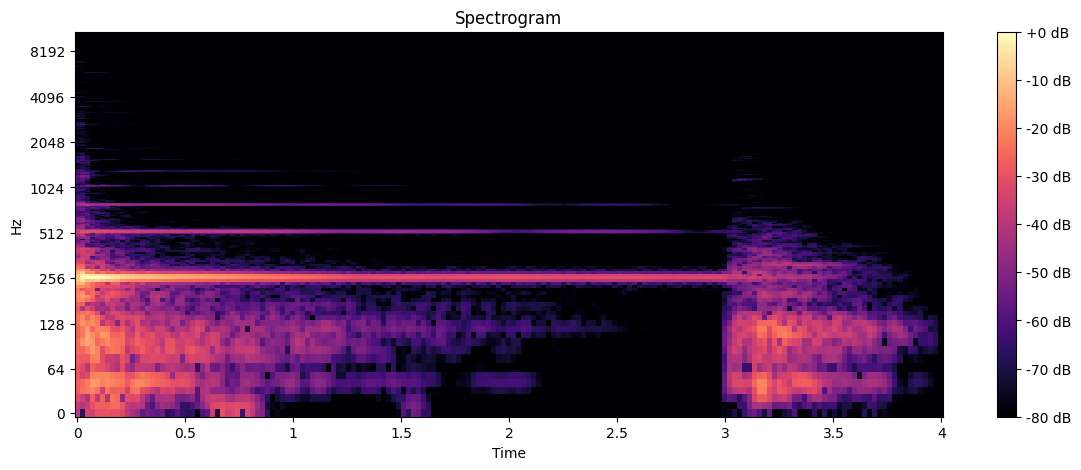

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
y, sample_rate = librosa.load('../../training-data/nsynth-valid/audio/' + first_example['note_str'] + '.wav')

# Compute the STFT
D = librosa.stft(y)

# Convert to dB
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(D_db, sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [ ]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

os.makedirs('../../training-data/nsynth-valid/spectrograms', exist_ok=True)

for key, _ in examples.items():
    # Load the audio file
    y, sr = librosa.load('../../training-data/nsynth-valid/audio/' + key + '.wav')

    # Compute the STFT
    D = librosa.stft(y)

    # Convert to dB
    D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

    # Get the shape of the data
    height, width = D_db.shape

    # Create a figure with size equal to the shape of the data
    plt.figure(figsize=(width, height), dpi=1, layout='tight', frameon=False)
    plt.axis('off')

    # Display the spectrogram
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')

    # Save the figure with dpi=1
    plt.savefig('../../training-data/nsynth-valid/spectrograms/' + key + '.png', bbox_inches='tight', pad_inches=0)
    plt.close()

## Create the DataLoaders

In [ ]:
from fastai.vision.all import *

def get_instrument_family(path):
    filename = os.path.basename(path)[:-4]
    example = examples[filename]
    return example['instrument_family_str']

dls = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_instrument_family
).dataloaders("../../training-data/nsynth-valid/spectrograms/", bs=64)

## Show one batch of data

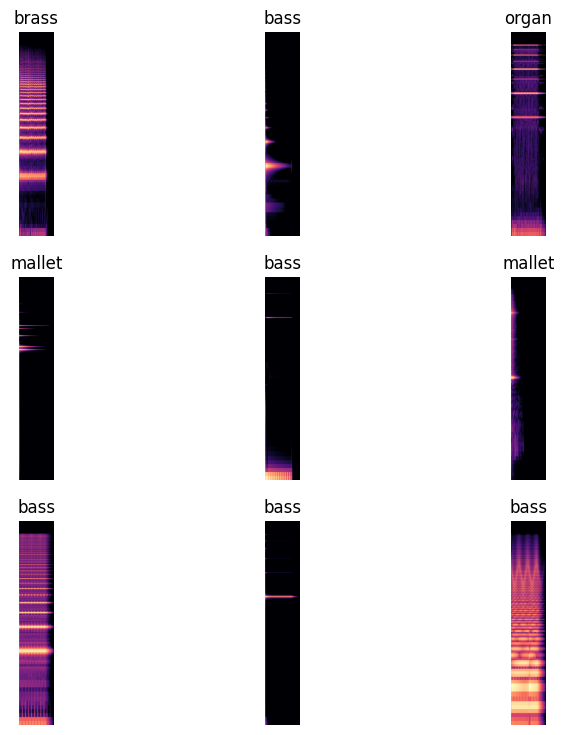

In [21]:
dls.show_batch()

## Fit the model

In [23]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.268163,0.301392,0.089546,04:22
1,0.268829,0.059755,0.017357,04:24
2,0.099671,0.028603,0.009862,04:22
3,0.056096,0.010125,0.001972,04:22
4,0.038010,0.008345,0.002761,04:22
5,0.020890,0.003364,0.000394,04:22
6,0.012525,0.001509,0.000789,04:22
7,0.009295,0.001324,0.000000,04:22
8,0.004983,0.000759,0.000000,04:23
9,0.004141,0.000727,0.000000,04:22


In [24]:
learn.save('audio-classifier')

Path('models/audio-classifier.pth')

## Test it against the first 20 examples

In [25]:
for example, data in first_20_examples.items():
    image = PILImage.create('../../training-data/nsynth-valid/spectrograms/' + example + '.png')
    actual_category = data['instrument_family_str']
    predicted_category, _, _ = learn.predict(image)
    print(f'Predicted: {predicted_category}, Actual: {actual_category}')

Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: mallet, Actual: mallet


Predicted: organ, Actual: organ


Predicted: keyboard, Actual: keyboard


Predicted: organ, Actual: organ


Predicted: brass, Actual: brass


Predicted: keyboard, Actual: keyboard


Predicted: bass, Actual: bass


Predicted: organ, Actual: organ


Predicted: guitar, Actual: guitar


Predicted: bass, Actual: bass


Predicted: bass, Actual: bass


Predicted: string, Actual: string


Predicted: organ, Actual: organ
